In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v6 import Autoencoder
from tools.GRU_SingleStep_v11 import RNN_GRU

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-01-11 02:23:37.079158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 02:23:37.079504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 02:23:37.114842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 02:23:37.115276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 02:23:37.115617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')

    # whether to use AE data or just work on raw data
    use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

    # autoencoder directory
    ae_idx = '067'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_015'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    try:
        use_ae_data = params_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in sim_data_AE_params, set to True.")
        normalize_dataset = True
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
    try:
        use_ae_data = params_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_067
data_dir_idx: 005
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

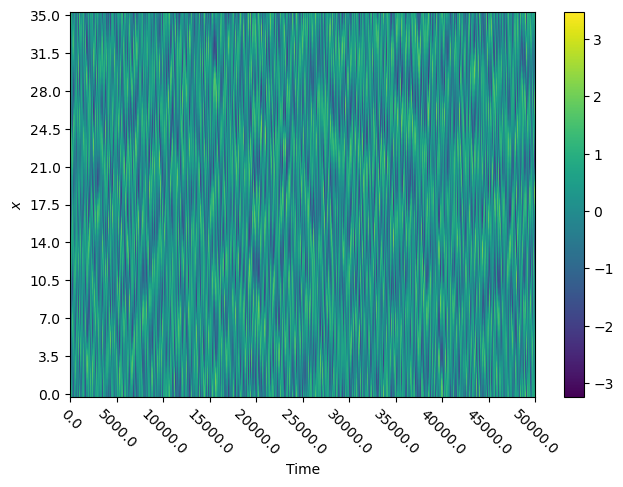

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# dealing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:numpoints_xgrid]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:numpoints_xgrid]

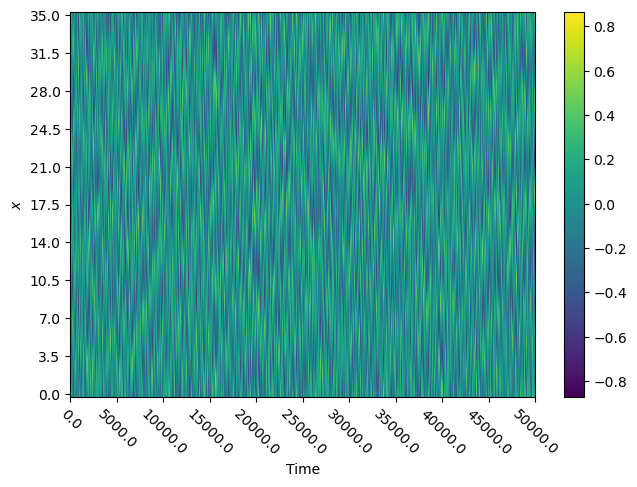

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [18]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [19]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

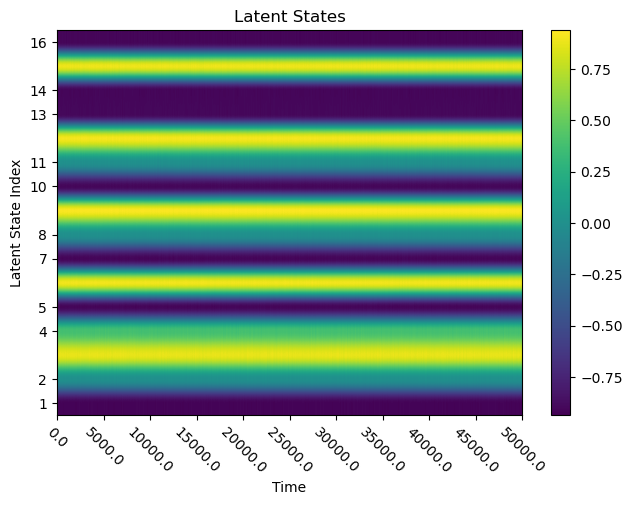

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 5 # int(5000/np.mean(lyapunov_time_arr))#
    dt_rnn = 0.2
    T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'

    # can be 'minmax', 'minmax2', 'stddev', or a list with
    # sequential order of any of these; if it is 'minmax'
    # then stddev_multiplier has no effect
    normalization_type = 'stddev'
    stddev_multiplier = 3

    dense_layer_act_func = ['tanh']
    use_weights_post_dense = True
    stateful = True
    use_learnable_state = False
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':RNN_GRU.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
        'dense_layer_act_func':dense_layer_act_func,
        'stateful':stateful,
        'use_learnable_state':use_learnable_state,
        'use_weights_post_dense':use_weights_post_dense,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    patience = 10 # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 5e-7  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 2/100
    zoneout_rate = 0.0
    rnncell_dropout_rate = 0.0
    denselayer_dropout_rate = 0.0
    

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'zoneout_rate':zoneout_rate,
        'rnncell_dropout_rate':rnncell_dropout_rate,
        'denselayer_dropout_rate':denselayer_dropout_rate,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * (int( (1-test_split-val_split)*num_samples )//batch_size)
    num_val_arr[i] = batch_size * (int(val_split*num_samples)//batch_size)
    num_test_arr[i] = batch_size * int((num_samples - num_train_arr[i] - num_val_arr[i])//batch_size)
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]


    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [29]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (512, 387, 16)
 testing_data_rnn_input.shape :  (64, 387, 16)
     val_data_rnn_input.shape :  (64, 387, 16)


In [30]:
# print(rnn_data_boundary_idx_arr)

In [31]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_layers_units = [500]*3
    scalar_weights = [1.0, 0.5, 0.5]
#     timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    dense_dim = [rnn_layers_units[-1]]*(len(dense_layer_act_func)-1)
    dense_dim.append(data_dim)
        
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                data_dim=data_dim,
            #     in_steps=int(T_sample_input // dt_rnn),
            #     out_steps=int(T_sample_output // dt_rnn),
                dt_rnn=dt_rnn,
                lambda_reg=lambda_reg,
                reg_name='L2',
                rnn_layers_units=rnn_layers_units,
                dense_layer_act_func=dense_layer_act_func,
                load_file=None,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                stddev=stddev,
                noise_type=noise_type,
                dense_dim=dense_dim,
                use_learnable_state=use_learnable_state,
                stateful=stateful,
                zoneout_rate=zoneout_rate,
                batch_size=batch_size,
                use_weights_post_dense=use_weights_post_dense,
                rnncell_dropout_rate=rnncell_dropout_rate,
                denselayer_dropout_rate=denselayer_dropout_rate,
                scalar_weights=scalar_weights, # corresponding to RK4
            )
    else:
        rnn_net = RNN_GRU(
            data_dim=data_dim,
        #     in_steps=int(T_sample_input // dt_rnn),
        #     out_steps=int(T_sample_output // dt_rnn),
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            reg_name='L2',
            rnn_layers_units=rnn_layers_units,
            dense_layer_act_func=dense_layer_act_func,
            load_file=None,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            stddev=stddev,
            noise_type=noise_type,
            dense_dim=dense_dim,
            use_learnable_state=use_learnable_state,
            stateful=stateful,
            zoneout_rate=zoneout_rate,
            batch_size=batch_size,
            use_weights_post_dense=use_weights_post_dense,
            rnncell_dropout_rate=rnncell_dropout_rate,
            denselayer_dropout_rate=denselayer_dropout_rate,
            scalar_weights=scalar_weights, # corresponding to RK4
        )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                batch_size=batch_size,
                
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            batch_size=batch_size
        )

    rnn_net.build(input_shape=(batch_size, None, num_latent_states))
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.33114633
stddev : 0.0066229265928268435


In [32]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [33]:
train_NMSE_hist = []
val_NMSE_hist = []

train_MSE_hist = []
val_MSE_hist = []

In [34]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [35]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    metrics=['mse', NMSE(divisor_arr=time_stddev)],
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1,
            shuffle=not stateful,
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])

        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
8/8 [==============================] - ETA: 0s - loss: 0.0342 - mse: 0.0333 - NMSE: 0.2999 - tot_time: 0h 0m 18.5s

Epoch 1: val_NMSE improved from inf to 0.09730, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 0.0342 - mse: 0.0333 - NMSE: 0.2999 - val_loss: 0.0117 - val_mse: 0.0108 - val_NMSE: 0.0973
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 0.0087 - mse: 0.0078 - NMSE: 0.0705 - tot_time: 0h 0m 33.9s

Epoch 2: val_NMSE improved from 0.09730 to 0.05057, saving model to /home

8/8 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0012 - NMSE: 0.0108 - tot_time: 0h 3m 53.8s

Epoch 15: val_NMSE improved from 0.01381 to 0.01328, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 0.0019 - mse: 0.0012 - NMSE: 0.0108 - val_loss: 0.0022 - val_mse: 0.0015 - val_NMSE: 0.0133
Epoch 16/1000
8/8 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0011 - NMSE: 0.0103 - tot_time: 0h 4m 9.4s

Epoch 16: val_NMSE improved from 0.01328 to 0.01282, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - los

Epoch 30/1000
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 7.7634e-04 - NMSE: 0.0070 - tot_time: 0h 7m 45.4s

Epoch 30: val_NMSE improved from 0.00952 to 0.00936, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 0.0013 - mse: 7.7634e-04 - NMSE: 0.0070 - val_loss: 0.0016 - val_mse: 0.0010 - val_NMSE: 0.0094
Epoch 31/1000
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 7.6150e-04 - NMSE: 0.0069 - tot_time: 0h 8m 0.6s

Epoch 31: val_NMSE improved from 0.00936 to 0.00921, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [=========================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 0.0010 - mse: 6.3070e-04 - NMSE: 0.0057 - val_loss: 0.0013 - val_mse: 8.5748e-04 - val_NMSE: 0.0077
Epoch 45/1000
8/8 [==============================] - ETA: 0s - loss: 0.0010 - mse: 6.1592e-04 - NMSE: 0.0055 - tot_time: 0h 11m 35.5s

Epoch 45: val_NMSE improved from 0.00772 to 0.00764, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 0.0010 - mse: 6.1592e-04 - NMSE: 0.0055 - val_loss: 0.0013 - val_mse: 8.4925e-04 - val_NMSE: 0.0076
Epoch 46/1000
8/8 [==============================] - ETA: 0s - loss: 0.0010 - mse: 6.0578e-04 - NMSE: 0.0055 - tot_time: 0h 11m 50.9s

Epoch 46: val_N

Epoch 59/1000
8/8 [==============================] - ETA: 0s - loss: 8.8248e-04 - mse: 5.2040e-04 - NMSE: 0.0047 - tot_time: 0h 15m 10.2s

Epoch 59: val_NMSE improved from 0.00661 to 0.00655, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 8.8248e-04 - mse: 5.2040e-04 - NMSE: 0.0047 - val_loss: 0.0011 - val_mse: 7.2774e-04 - val_NMSE: 0.0066
Epoch 60/1000
8/8 [==============================] - ETA: 0s - loss: 8.7396e-04 - mse: 5.1404e-04 - NMSE: 0.0046 - tot_time: 0h 15m 25.7s

Epoch 60: val_NMSE improved from 0.00655 to 0.00649, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [======

Epoch 74/1000
8/8 [==============================] - ETA: 0s - loss: 7.6003e-04 - mse: 4.2114e-04 - NMSE: 0.0038 - tot_time: 0h 18m 59.3s

Epoch 74: val_NMSE improved from 0.00558 to 0.00551, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 7.6003e-04 - mse: 4.2114e-04 - NMSE: 0.0038 - val_loss: 9.5048e-04 - val_mse: 6.1226e-04 - val_NMSE: 0.0055
Epoch 75/1000
8/8 [==============================] - ETA: 0s - loss: 7.5252e-04 - mse: 4.1480e-04 - NMSE: 0.0037 - tot_time: 0h 19m 14.6s

Epoch 75: val_NMSE improved from 0.00551 to 0.00546, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 6.9162e-04 - mse: 3.6710e-04 - NMSE: 0.0033 - val_loss: 8.6528e-04 - val_mse: 5.4125e-04 - val_NMSE: 0.0049
Epoch 89/1000
8/8 [==============================] - ETA: 0s - loss: 6.8631e-04 - mse: 3.6266e-04 - NMSE: 0.0033 - tot_time: 0h 22m 49.7s

Epoch 89: val_NMSE improved from 0.00487 to 0.00481, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 6.8631e-04 - mse: 3.6266e-04 - NMSE: 0.0033 - val_loss: 8.5763e-04 - val_mse: 5.3447e-04 - val_NMSE: 0.0048
Epoch 90/1000
8/8 [==============================] - ETA: 0s - loss: 6.8242e-04 - mse: 3.5964e-04 - NMSE: 0.0032 - tot_time: 0h 23

Epoch 103/1000
8/8 [==============================] - ETA: 0s - loss: 6.3782e-04 - mse: 3.2576e-04 - NMSE: 0.0029 - tot_time: 0h 26m 25.5s

Epoch 103: val_NMSE improved from 0.00441 to 0.00438, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 6.3782e-04 - mse: 3.2576e-04 - NMSE: 0.0029 - val_loss: 7.9796e-04 - val_mse: 4.8636e-04 - val_NMSE: 0.0044
Epoch 104/1000
8/8 [==============================] - ETA: 0s - loss: 6.3503e-04 - mse: 3.2376e-04 - NMSE: 0.0029 - tot_time: 0h 26m 40.8s

Epoch 104: val_NMSE improved from 0.00438 to 0.00435, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 6.0165e-04 - mse: 3.0023e-04 - NMSE: 0.0027 - val_loss: 7.5135e-04 - val_mse: 4.5034e-04 - val_NMSE: 0.0041
Epoch 118/1000
8/8 [==============================] - ETA: 0s - loss: 5.9438e-04 - mse: 2.9369e-04 - NMSE: 0.0026 - tot_time: 0h 30m 15.8s

Epoch 118: val_NMSE improved from 0.00405 to 0.00399, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 5.9438e-04 - mse: 2.9369e-04 - NMSE: 0.0026 - val_loss: 7.4341e-04 - val_mse: 4.4313e-04 - val_NMSE: 0.0040
Epoch 119/1000
8/8 [==============================] - ETA: 0s - loss: 5.9001e-04 - mse: 2.9005e-04 - NMSE: 0.0026 - tot_time: 0h

Epoch 133/1000
8/8 [==============================] - ETA: 0s - loss: 5.4624e-04 - mse: 2.5622e-04 - NMSE: 0.0023 - tot_time: 0h 34m 5.4s

Epoch 133: val_NMSE did not improve from 0.00355
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 5.4624e-04 - mse: 2.5622e-04 - NMSE: 0.0023 - val_loss: 6.8432e-04 - val_mse: 3.9471e-04 - val_NMSE: 0.0036
Epoch 134/1000
8/8 [==============================] - ETA: 0s - loss: 5.4800e-04 - mse: 2.5868e-04 - NMSE: 0.0023 - tot_time: 0h 34m 20.8s

Epoch 134: val_NMSE did not improve from 0.00355
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 5.4800e-04 - mse: 2.5868e-04 - NMSE: 0.0023 - val_loss: 6.9343e-04 - val_mse: 4.0451e-04 - val_NMSE: 0.0036
Epoch 135/1000
8/8 [=======================

Epoch 149/1000
8/8 [==============================] - ETA: 0s - loss: 4.8569e-04 - mse: 2.0701e-04 - NMSE: 0.0019 - tot_time: 0h 38m 9.5s

Epoch 149: val_NMSE improved from 0.00318 to 0.00317, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 4.8569e-04 - mse: 2.0701e-04 - NMSE: 0.0019 - val_loss: 6.3019e-04 - val_mse: 3.5194e-04 - val_NMSE: 0.0032
Epoch 150/1000
8/8 [==============================] - ETA: 0s - loss: 4.8308e-04 - mse: 2.0515e-04 - NMSE: 0.0018 - tot_time: 0h 38m 24.9s

Epoch 150: val_NMSE improved from 0.00317 to 0.00309, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 

8/8 [==============================] - ETA: 0s - loss: 4.5002e-04 - mse: 1.8245e-04 - NMSE: 0.0016 - tot_time: 0h 41m 59.7s

Epoch 164: val_NMSE did not improve from 0.00278
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 4.5002e-04 - mse: 1.8245e-04 - NMSE: 0.0016 - val_loss: 5.7625e-04 - val_mse: 3.0910e-04 - val_NMSE: 0.0028
Epoch 165/1000
8/8 [==============================] - ETA: 0s - loss: 4.4672e-04 - mse: 1.7988e-04 - NMSE: 0.0016 - tot_time: 0h 42m 14.9s

Epoch 165: val_NMSE improved from 0.00278 to 0.00275, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 4.4672e-04 - mse: 1.7988e-04 - NMSE: 0.0016 - val_loss: 5.7238

Epoch 180/1000
8/8 [==============================] - ETA: 0s - loss: 4.1954e-04 - mse: 1.6369e-04 - NMSE: 0.0015 - tot_time: 0h 46m 3.6s

Epoch 180: val_NMSE improved from 0.00255 to 0.00253, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 4.1954e-04 - mse: 1.6369e-04 - NMSE: 0.0015 - val_loss: 5.3627e-04 - val_mse: 2.8084e-04 - val_NMSE: 0.0025
Epoch 181/1000
8/8 [==============================] - ETA: 0s - loss: 4.1767e-04 - mse: 1.6257e-04 - NMSE: 0.0015 - tot_time: 0h 46m 18.9s

Epoch 181: val_NMSE improved from 0.00253 to 0.00251, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 4.0145e-04 - mse: 1.5647e-04 - NMSE: 0.0014 - val_loss: 5.1924e-04 - val_mse: 2.7466e-04 - val_NMSE: 0.0025
Epoch 196/1000
8/8 [==============================] - ETA: 0s - loss: 3.9753e-04 - mse: 1.5325e-04 - NMSE: 0.0014 - tot_time: 0h 50m 8.3s

Epoch 196: val_NMSE improved from 0.00245 to 0.00234, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.9753e-04 - mse: 1.5325e-04 - NMSE: 0.0014 - val_loss: 5.0383e-04 - val_mse: 2.5995e-04 - val_NMSE: 0.0023
Epoch 197/1000
8/8 [==============================] - ETA: 0s - loss: 3.9286e-04 - mse: 1.4928e-04 - NMSE: 0.0013 - tot_time: 0h 

Epoch 211/1000
8/8 [==============================] - ETA: 0s - loss: 3.7982e-04 - mse: 1.4606e-04 - NMSE: 0.0013 - tot_time: 0h 53m 57.9s

Epoch 211: val_NMSE did not improve from 0.00219
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.7982e-04 - mse: 1.4606e-04 - NMSE: 0.0013 - val_loss: 4.8389e-04 - val_mse: 2.5053e-04 - val_NMSE: 0.0023
Epoch 212/1000
8/8 [==============================] - ETA: 0s - loss: 3.8401e-04 - mse: 1.5095e-04 - NMSE: 0.0014 - tot_time: 0h 54m 13.1s

Epoch 212: val_NMSE did not improve from 0.00219
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.8401e-04 - mse: 1.5095e-04 - NMSE: 0.0014 - val_loss: 4.8795e-04 - val_mse: 2.5528e-04 - val_NMSE: 0.0023
Epoch 213/1000
8/8 [======================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.5639e-04 - mse: 1.3342e-04 - NMSE: 0.0012 - val_loss: 4.5648e-04 - val_mse: 2.3389e-04 - val_NMSE: 0.0021
Epoch 228/1000
8/8 [==============================] - ETA: 0s - loss: 3.5287e-04 - mse: 1.3055e-04 - NMSE: 0.0012 - tot_time: 0h 58m 17.2s

Epoch 228: val_NMSE did not improve from 0.00210
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.5287e-04 - mse: 1.3055e-04 - NMSE: 0.0012 - val_loss: 4.5689e-04 - val_mse: 2.3494e-04 - val_NMSE: 0.0021
Epoch 229/1000
8/8 [==============================] - ETA: 0s - loss: 3.5036e-04 - mse: 1.2868e-04 - NMSE: 0.0012 - tot_time: 0h 58m 32.4s

Epoch 229: val_NMSE did not improve from 0.00210
 - saving loss histories at /home/rkaushik

8/8 [==============================] - ETA: 0s - loss: 3.3534e-04 - mse: 1.2284e-04 - NMSE: 0.0011 - tot_time: 1h 2m 7.5s

Epoch 243: val_NMSE did not improve from 0.00193
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.3534e-04 - mse: 1.2284e-04 - NMSE: 0.0011 - val_loss: 4.3916e-04 - val_mse: 2.2701e-04 - val_NMSE: 0.0020
Epoch 244/1000
8/8 [==============================] - ETA: 0s - loss: 3.3610e-04 - mse: 1.2423e-04 - NMSE: 0.0011 - tot_time: 1h 2m 22.7s

Epoch 244: val_NMSE did not improve from 0.00193
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.3610e-04 - mse: 1.2423e-04 - NMSE: 0.0011 - val_loss: 4.3823e-04 - val_mse: 2.2671e-04 - val_NMSE: 0.0020
Epoch 245/1000
8/8 [==============================] - ETA: 0

8/8 [==============================] - ETA: 0s - loss: 3.1146e-04 - mse: 1.0894e-04 - NMSE: 9.8063e-04 - tot_time: 1h 6m 13.3s

Epoch 259: val_NMSE improved from 0.00181 to 0.00181, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.1146e-04 - mse: 1.0894e-04 - NMSE: 9.8063e-04 - val_loss: 4.0294e-04 - val_mse: 2.0077e-04 - val_NMSE: 0.0018
Epoch 260/1000
8/8 [==============================] - ETA: 0s - loss: 3.1107e-04 - mse: 1.0917e-04 - NMSE: 9.8269e-04 - tot_time: 1h 6m 28.6s

Epoch 260: val_NMSE did not improve from 0.00181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.1107e-04 - mse: 1.0917e-04 - NMSE: 9.8269e-04 - va

Epoch 9/1000
8/8 [==============================] - ETA: 0s - loss: 2.9788e-04 - mse: 9.3774e-05 - NMSE: 8.4410e-04 - tot_time: 1h 10m 3.1s

Epoch 9: val_NMSE did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.9788e-04 - mse: 9.3774e-05 - NMSE: 8.4410e-04 - val_loss: 3.9424e-04 - val_mse: 1.9017e-04 - val_NMSE: 0.0017
Epoch 10/1000
8/8 [==============================] - ETA: 0s - loss: 2.9765e-04 - mse: 9.3609e-05 - NMSE: 8.4261e-04 - tot_time: 1h 10m 18.4s

Epoch 10: val_NMSE improved from 0.00171 to 0.00171, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.9765e-04 - mse: 9.3609e-05 - NMSE: 8.426

Epoch 24/1000
8/8 [==============================] - ETA: 0s - loss: 2.9600e-04 - mse: 9.2984e-05 - NMSE: 8.3698e-04 - tot_time: 1h 13m 53.5s

Epoch 24: val_NMSE did not improve from 0.00170
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.9600e-04 - mse: 9.2984e-05 - NMSE: 8.3698e-04 - val_loss: 3.9249e-04 - val_mse: 1.8952e-04 - val_NMSE: 0.0017
Epoch 25/1000
8/8 [==============================] - ETA: 0s - loss: 2.9592e-04 - mse: 9.2974e-05 - NMSE: 8.3689e-04 - tot_time: 1h 14m 8.8s

Epoch 25: val_NMSE did not improve from 0.00170
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.9592e-04 - mse: 9.2974e-05 - NMSE: 8.3689e-04 - val_loss: 3.9237e-04 - val_mse: 1.8947e-04 - val_NMSE: 0.0017
Epoch 26/1000
8/8 [============

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.9437e-04 - mse: 9.2497e-05 - NMSE: 8.3260e-04 - val_loss: 3.9041e-04 - val_mse: 1.8858e-04 - val_NMSE: 0.0017
Epoch 40/1000
8/8 [==============================] - ETA: 0s - loss: 2.9434e-04 - mse: 9.2542e-05 - NMSE: 8.3300e-04 - tot_time: 1h 17m 58.5s

Epoch 40: val_NMSE did not improve from 0.00170
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.9434e-04 - mse: 9.2542e-05 - NMSE: 8.3300e-04 - val_loss: 3.9048e-04 - val_mse: 1.8873e-04 - val_NMSE: 0.0017
Epoch 41/1000
8/8 [==============================] - ETA: 0s - loss: 2.9411e-04 - mse: 9.2395e-05 - NMSE: 8.3168e-04 - tot_time: 1h 18m 13.6s

Epoch 41: val_NMSE improved from 0.00170 to 0.00170, saving model to /home/rka

8/8 [==============================] - ETA: 0s - loss: 2.9253e-04 - mse: 9.1937e-05 - NMSE: 8.2756e-04 - tot_time: 1h 21m 47.0s

Epoch 55: val_NMSE improved from 0.00169 to 0.00169, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.9253e-04 - mse: 9.1937e-05 - NMSE: 8.2756e-04 - val_loss: 3.8831e-04 - val_mse: 1.8777e-04 - val_NMSE: 0.0017
Epoch 56/1000
8/8 [==============================] - ETA: 0s - loss: 2.9233e-04 - mse: 9.1821e-05 - NMSE: 8.2651e-04 - tot_time: 1h 22m 2.2s

Epoch 56: val_NMSE did not improve from 0.00169
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.9233e-04 - mse: 9.1821e-05 - NMSE: 8.2651e-04 - val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.9060e-04 - mse: 9.1275e-05 - NMSE: 8.2160e-04 - val_loss: 3.8635e-04 - val_mse: 1.8707e-04 - val_NMSE: 0.0017
Epoch 71/1000
8/8 [==============================] - ETA: 0s - loss: 2.9040e-04 - mse: 9.1160e-05 - NMSE: 8.2056e-04 - tot_time: 1h 25m 51.2s

Epoch 71: val_NMSE did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.9040e-04 - mse: 9.1160e-05 - NMSE: 8.2056e-04 - val_loss: 3.8646e-04 - val_mse: 1.8727e-04 - val_NMSE: 0.0017
Epoch 72/1000
8/8 [==============================] - ETA: 0s - loss: 2.9041e-04 - mse: 9.1254e-05 - NMSE: 8.2141e-04 - tot_time: 1h 26m 6.4s

Epoch 72: val_NMSE improved from 0.00168 to 0.00168, saving model to /home/rkau

Epoch 86/1000
8/8 [==============================] - ETA: 0s - loss: 2.8867e-04 - mse: 9.0744e-05 - NMSE: 8.1682e-04 - tot_time: 1h 29m 40.3s

Epoch 86: val_NMSE did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.8867e-04 - mse: 9.0744e-05 - NMSE: 8.1682e-04 - val_loss: 3.8429e-04 - val_mse: 1.8642e-04 - val_NMSE: 0.0017
Epoch 87/1000
8/8 [==============================] - ETA: 0s - loss: 2.8863e-04 - mse: 9.0792e-05 - NMSE: 8.1725e-04 - tot_time: 1h 29m 55.6s

Epoch 87: val_NMSE improved from 0.00168 to 0.00168, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.8863e-04 - mse: 9.0792e-05 - NMSE: 8.

Epoch 102/1000
8/8 [==============================] - ETA: 0s - loss: 2.8677e-04 - mse: 9.0311e-05 - NMSE: 8.1292e-04 - tot_time: 1h 33m 44.8s

Epoch 102: val_NMSE improved from 0.00167 to 0.00167, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.8677e-04 - mse: 9.0311e-05 - NMSE: 8.1292e-04 - val_loss: 3.8175e-04 - val_mse: 1.8535e-04 - val_NMSE: 0.0017
Epoch 103/1000
8/8 [==============================] - ETA: 0s - loss: 2.8665e-04 - mse: 9.0286e-05 - NMSE: 8.1270e-04 - tot_time: 1h 34m 0.1s

Epoch 103: val_NMSE improved from 0.00167 to 0.00167, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesChe

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.8472e-04 - mse: 8.9698e-05 - NMSE: 8.0741e-04 - val_loss: 3.7971e-04 - val_mse: 1.8474e-04 - val_NMSE: 0.0017
Epoch 118/1000
8/8 [==============================] - ETA: 0s - loss: 2.8462e-04 - mse: 8.9693e-05 - NMSE: 8.0736e-04 - tot_time: 1h 37m 50.6s

Epoch 118: val_NMSE did not improve from 0.00166
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.8462e-04 - mse: 8.9693e-05 - NMSE: 8.0736e-04 - val_loss: 3.7943e-04 - val_mse: 1.8456e-04 - val_NMSE: 0.0017
Epoch 119/1000
8/8 [==============================] - ETA: 0s - loss: 2.8445e-04 - mse: 8.9615e-05 - NMSE: 8.0666e-04 - tot_time: 1h 38m 5.9s

Epoch 119: val_NMSE did not improve from 0.00166
 - saving loss histories at

8/8 [==============================] - ETA: 0s - loss: 2.8255e-04 - mse: 8.9006e-05 - NMSE: 8.0117e-04 - tot_time: 1h 41m 25.2s

Epoch 132: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.8255e-04 - mse: 8.9006e-05 - NMSE: 8.0117e-04 - val_loss: 3.7701e-04 - val_mse: 1.8352e-04 - val_NMSE: 0.0017
Epoch 133/1000
8/8 [==============================] - ETA: 0s - loss: 2.8253e-04 - mse: 8.9095e-05 - NMSE: 8.0198e-04 - tot_time: 1h 41m 40.4s

Epoch 133: val_NMSE improved from 0.00165 to 0.00165, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.8253e-04 - mse: 8.9095e-05 - NMSE: 8.0198e-04 - 

Epoch 147/1000
8/8 [==============================] - ETA: 0s - loss: 2.8032e-04 - mse: 8.8321e-05 - NMSE: 7.9501e-04 - tot_time: 1h 45m 14.8s

Epoch 147: val_NMSE did not improve from 0.00164
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.8032e-04 - mse: 8.8321e-05 - NMSE: 7.9501e-04 - val_loss: 3.7425e-04 - val_mse: 1.8232e-04 - val_NMSE: 0.0016
Epoch 148/1000
8/8 [==============================] - ETA: 0s - loss: 2.8004e-04 - mse: 8.8154e-05 - NMSE: 7.9350e-04 - tot_time: 1h 45m 30.1s

Epoch 148: val_NMSE improved from 0.00164 to 0.00164, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.8004e-04 - mse: 8.8154e-05 - NMSE

Epoch 162/1000
8/8 [==============================] - ETA: 0s - loss: 2.7764e-04 - mse: 8.7244e-05 - NMSE: 7.8532e-04 - tot_time: 1h 49m 4.3s

Epoch 162: val_NMSE did not improve from 0.00163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.7764e-04 - mse: 8.7244e-05 - NMSE: 7.8532e-04 - val_loss: 3.7124e-04 - val_mse: 1.8090e-04 - val_NMSE: 0.0016
Epoch 163/1000
8/8 [==============================] - ETA: 0s - loss: 2.7738e-04 - mse: 8.7094e-05 - NMSE: 7.8396e-04 - tot_time: 1h 49m 19.5s

Epoch 163: val_NMSE improved from 0.00163 to 0.00163, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.7738e-04 - mse: 8.7094e-05 - NMSE:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.7517e-04 - mse: 8.6315e-05 - NMSE: 7.7695e-04 - val_loss: 3.6867e-04 - val_mse: 1.7988e-04 - val_NMSE: 0.0016
Epoch 177/1000
8/8 [==============================] - ETA: 0s - loss: 2.7499e-04 - mse: 8.6251e-05 - NMSE: 7.7638e-04 - tot_time: 1h 52m 54.4s

Epoch 177: val_NMSE improved from 0.00162 to 0.00162, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.7499e-04 - mse: 8.6251e-05 - NMSE: 7.7638e-04 - val_loss: 3.6826e-04 - val_mse: 1.7959e-04 - val_NMSE: 0.0016
Epoch 178/1000
8/8 [==============================] - ETA: 0s - loss: 2.7474e-04 - mse: 8.6114e-05 - NMSE: 7.7514e-0

Epoch 191/1000
8/8 [==============================] - ETA: 0s - loss: 2.7250e-04 - mse: 8.5357e-05 - NMSE: 7.6833e-04 - tot_time: 1h 56m 28.1s

Epoch 191: val_NMSE improved from 0.00161 to 0.00160, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.7250e-04 - mse: 8.5357e-05 - NMSE: 7.6833e-04 - val_loss: 3.6531e-04 - val_mse: 1.7822e-04 - val_NMSE: 0.0016
Epoch 192/1000
8/8 [==============================] - ETA: 0s - loss: 2.7227e-04 - mse: 8.5234e-05 - NMSE: 7.6723e-04 - tot_time: 1h 56m 43.5s

Epoch 192: val_NMSE improved from 0.00160 to 0.00160, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCh

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.6994e-04 - mse: 8.4442e-05 - NMSE: 7.6009e-04 - val_loss: 3.6231e-04 - val_mse: 1.7688e-04 - val_NMSE: 0.0016
Epoch 206/1000
8/8 [==============================] - ETA: 0s - loss: 2.6967e-04 - mse: 8.4284e-05 - NMSE: 7.5868e-04 - tot_time: 2h 0m 18.3s

Epoch 206: val_NMSE improved from 0.00159 to 0.00159, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.6967e-04 - mse: 8.4284e-05 - NMSE: 7.5868e-04 - val_loss: 3.6212e-04 - val_mse: 1.7681e-04 - val_NMSE: 0.0016
Epoch 207/1000
8/8 [==============================] - ETA: 0s - loss: 2.6960e-04 - mse: 8.4337e-05 - NMSE: 7.5915e-04

Epoch 220/1000
8/8 [==============================] - ETA: 0s - loss: 2.6712e-04 - mse: 8.3439e-05 - NMSE: 7.5107e-04 - tot_time: 2h 3m 52.8s

Epoch 220: val_NMSE improved from 0.00158 to 0.00158, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.6712e-04 - mse: 8.3439e-05 - NMSE: 7.5107e-04 - val_loss: 3.5904e-04 - val_mse: 1.7542e-04 - val_NMSE: 0.0016
Epoch 221/1000
8/8 [==============================] - ETA: 0s - loss: 2.6694e-04 - mse: 8.3382e-05 - NMSE: 7.5055e-04 - tot_time: 2h 4m 8.1s

Epoch 221: val_NMSE improved from 0.00158 to 0.00158, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheck

Epoch 235/1000
8/8 [==============================] - ETA: 0s - loss: 2.6435e-04 - mse: 8.2543e-05 - NMSE: 7.4300e-04 - tot_time: 2h 7m 42.6s

Epoch 235: val_NMSE improved from 0.00157 to 0.00157, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.6435e-04 - mse: 8.2543e-05 - NMSE: 7.4300e-04 - val_loss: 3.5560e-04 - val_mse: 1.7386e-04 - val_NMSE: 0.0016
Epoch 236/1000
8/8 [==============================] - ETA: 0s - loss: 2.6401e-04 - mse: 8.2331e-05 - NMSE: 7.4110e-04 - tot_time: 2h 7m 57.8s

Epoch 236: val_NMSE improved from 0.00157 to 0.00156, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesChec

Epoch 250/1000
8/8 [==============================] - ETA: 0s - loss: 2.6141e-04 - mse: 8.1529e-05 - NMSE: 7.3387e-04 - tot_time: 2h 11m 32.8s

Epoch 250: val_NMSE improved from 0.00155 to 0.00155, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.6141e-04 - mse: 8.1529e-05 - NMSE: 7.3387e-04 - val_loss: 3.5226e-04 - val_mse: 1.7245e-04 - val_NMSE: 0.0016
Epoch 251/1000
8/8 [==============================] - ETA: 0s - loss: 2.6122e-04 - mse: 8.1471e-05 - NMSE: 7.3336e-04 - tot_time: 2h 11m 48.2s

Epoch 251: val_NMSE improved from 0.00155 to 0.00155, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCh

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.5853e-04 - mse: 8.0490e-05 - NMSE: 7.2452e-04 - val_loss: 3.4883e-04 - val_mse: 1.7087e-04 - val_NMSE: 0.0015
Epoch 265/1000
8/8 [==============================] - ETA: 0s - loss: 2.5828e-04 - mse: 8.0376e-05 - NMSE: 7.2350e-04 - tot_time: 2h 15m 23.1s

Epoch 265: val_NMSE did not improve from 0.00154
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.5828e-04 - mse: 8.0376e-05 - NMSE: 7.2350e-04 - val_loss: 3.4872e-04 - val_mse: 1.7089e-04 - val_NMSE: 0.0015
Epoch 266/1000
8/8 [==============================] - ETA: 0s - loss: 2.5802e-04 - mse: 8.0253e-05 - NMSE: 7.2238e-04 - tot_time: 2h 15m 38.3s

Epoch 266: val_NMSE improved from 0.00154 to 0.00154, saving model to /home

Epoch 279/1000
8/8 [==============================] - ETA: 0s - loss: 2.5534e-04 - mse: 7.9330e-05 - NMSE: 7.1408e-04 - tot_time: 2h 18m 57.8s

Epoch 279: val_NMSE improved from 0.00152 to 0.00152, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.5534e-04 - mse: 7.9330e-05 - NMSE: 7.1408e-04 - val_loss: 3.4519e-04 - val_mse: 1.6926e-04 - val_NMSE: 0.0015
Epoch 280/1000
8/8 [==============================] - ETA: 0s - loss: 2.5511e-04 - mse: 7.9239e-05 - NMSE: 7.1326e-04 - tot_time: 2h 19m 13.1s

Epoch 280: val_NMSE improved from 0.00152 to 0.00152, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCh

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.5242e-04 - mse: 7.8348e-05 - NMSE: 7.0524e-04 - val_loss: 3.4140e-04 - val_mse: 1.6740e-04 - val_NMSE: 0.0015
Epoch 294/1000
8/8 [==============================] - ETA: 0s - loss: 2.5217e-04 - mse: 7.8236e-05 - NMSE: 7.0423e-04 - tot_time: 2h 22m 47.9s

Epoch 294: val_NMSE did not improve from 0.00151
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.5217e-04 - mse: 7.8236e-05 - NMSE: 7.0423e-04 - val_loss: 3.4147e-04 - val_mse: 1.6762e-04 - val_NMSE: 0.0015
Epoch 295/1000
8/8 [==============================] - ETA: 0s - loss: 2.5201e-04 - mse: 7.8219e-05 - NMSE: 7.0408e-04 - tot_time: 2h 23m 2.9s

Epoch 295: val_NMSE improved from 0.00151 to 0.00151, saving model to /home/

Epoch 308/1000
8/8 [==============================] - ETA: 0s - loss: 2.4921e-04 - mse: 7.7256e-05 - NMSE: 6.9541e-04 - tot_time: 2h 26m 22.5s

Epoch 308: val_NMSE improved from 0.00149 to 0.00149, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.4921e-04 - mse: 7.7256e-05 - NMSE: 6.9541e-04 - val_loss: 3.3753e-04 - val_mse: 1.6566e-04 - val_NMSE: 0.0015
Epoch 309/1000
8/8 [==============================] - ETA: 0s - loss: 2.4897e-04 - mse: 7.7158e-05 - NMSE: 6.9453e-04 - tot_time: 2h 26m 37.7s

Epoch 309: val_NMSE did not improve from 0.00149
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.4897e-04 - mse: 7.7158e-05 - NMSE

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.4606e-04 - mse: 7.6121e-05 - NMSE: 6.8519e-04 - val_loss: 3.3381e-04 - val_mse: 1.6396e-04 - val_NMSE: 0.0015
Epoch 323/1000
8/8 [==============================] - ETA: 0s - loss: 2.4589e-04 - mse: 7.6104e-05 - NMSE: 6.8505e-04 - tot_time: 2h 30m 13.1s

Epoch 323: val_NMSE did not improve from 0.00148
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.4589e-04 - mse: 7.6104e-05 - NMSE: 6.8505e-04 - val_loss: 3.3367e-04 - val_mse: 1.6396e-04 - val_NMSE: 0.0015
Epoch 324/1000
8/8 [==============================] - ETA: 0s - loss: 2.4572e-04 - mse: 7.6071e-05 - NMSE: 6.8475e-04 - tot_time: 2h 30m 28.2s

Epoch 324: val_NMSE improved from 0.00148 to 0.00147, saving model to /home

8/8 [==============================] - ETA: 0s - loss: 2.4283e-04 - mse: 7.5093e-05 - NMSE: 6.7594e-04 - tot_time: 2h 33m 47.6s

Epoch 337: val_NMSE improved from 0.00146 to 0.00146, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.4283e-04 - mse: 7.5093e-05 - NMSE: 6.7594e-04 - val_loss: 3.2997e-04 - val_mse: 1.6231e-04 - val_NMSE: 0.0015
Epoch 338/1000
8/8 [==============================] - ETA: 0s - loss: 2.4273e-04 - mse: 7.5136e-05 - NMSE: 6.7633e-04 - tot_time: 2h 34m 2.8s

Epoch 338: val_NMSE improved from 0.00146 to 0.00146, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==

Epoch 352/1000
8/8 [==============================] - ETA: 0s - loss: 2.3957e-04 - mse: 7.4049e-05 - NMSE: 6.6654e-04 - tot_time: 2h 37m 37.4s

Epoch 352: val_NMSE improved from 0.00145 to 0.00144, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.3957e-04 - mse: 7.4049e-05 - NMSE: 6.6654e-04 - val_loss: 3.2577e-04 - val_mse: 1.6033e-04 - val_NMSE: 0.0014
Epoch 353/1000
8/8 [==============================] - ETA: 0s - loss: 2.3945e-04 - mse: 7.4078e-05 - NMSE: 6.6680e-04 - tot_time: 2h 37m 52.8s

Epoch 353: val_NMSE improved from 0.00144 to 0.00144, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCh

8/8 [==============================] - ETA: 0s - loss: 2.3672e-04 - mse: 7.3273e-05 - NMSE: 6.5955e-04 - tot_time: 2h 41m 11.9s

Epoch 366: val_NMSE improved from 0.00143 to 0.00143, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.3672e-04 - mse: 7.3273e-05 - NMSE: 6.5955e-04 - val_loss: 3.2196e-04 - val_mse: 1.5860e-04 - val_NMSE: 0.0014
Epoch 367/1000
8/8 [==============================] - ETA: 0s - loss: 2.3652e-04 - mse: 7.3222e-05 - NMSE: 6.5910e-04 - tot_time: 2h 41m 27.4s

Epoch 367: val_NMSE improved from 0.00143 to 0.00142, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [=

Epoch 381/1000
8/8 [==============================] - ETA: 0s - loss: 2.3356e-04 - mse: 7.2350e-05 - NMSE: 6.5125e-04 - tot_time: 2h 45m 2.2s

Epoch 381: val_NMSE improved from 0.00141 to 0.00141, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.3356e-04 - mse: 7.2350e-05 - NMSE: 6.5125e-04 - val_loss: 3.1792e-04 - val_mse: 1.5678e-04 - val_NMSE: 0.0014
Epoch 382/1000
8/8 [==============================] - ETA: 0s - loss: 2.3326e-04 - mse: 7.2196e-05 - NMSE: 6.4986e-04 - tot_time: 2h 45m 17.7s

Epoch 382: val_NMSE did not improve from 0.00141
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.3326e-04 - mse: 7.2196e-05 - NMSE:

Epoch 396/1000
8/8 [==============================] - ETA: 0s - loss: 2.3038e-04 - mse: 7.1379e-05 - NMSE: 6.4251e-04 - tot_time: 2h 48m 52.7s

Epoch 396: val_NMSE improved from 0.00140 to 0.00140, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.3038e-04 - mse: 7.1379e-05 - NMSE: 6.4251e-04 - val_loss: 3.1392e-04 - val_mse: 1.5500e-04 - val_NMSE: 0.0014
Epoch 397/1000
8/8 [==============================] - ETA: 0s - loss: 2.3014e-04 - mse: 7.1290e-05 - NMSE: 6.4171e-04 - tot_time: 2h 49m 7.9s

Epoch 397: val_NMSE improved from 0.00140 to 0.00139, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesChe

Epoch 411/1000
8/8 [==============================] - ETA: 0s - loss: 2.2731e-04 - mse: 7.0505e-05 - NMSE: 6.3464e-04 - tot_time: 2h 52m 43.0s

Epoch 411: val_NMSE improved from 0.00138 to 0.00138, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.2731e-04 - mse: 7.0505e-05 - NMSE: 6.3464e-04 - val_loss: 3.0999e-04 - val_mse: 1.5327e-04 - val_NMSE: 0.0014
Epoch 412/1000
8/8 [==============================] - ETA: 0s - loss: 2.2713e-04 - mse: 7.0474e-05 - NMSE: 6.3436e-04 - tot_time: 2h 52m 58.5s

Epoch 412: val_NMSE improved from 0.00138 to 0.00138, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCh

Epoch 426/1000
8/8 [==============================] - ETA: 0s - loss: 2.2430e-04 - mse: 6.9672e-05 - NMSE: 6.2715e-04 - tot_time: 2h 56m 34.9s

Epoch 426: val_NMSE improved from 0.00137 to 0.00136, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.2430e-04 - mse: 6.9672e-05 - NMSE: 6.2715e-04 - val_loss: 3.0617e-04 - val_mse: 1.5162e-04 - val_NMSE: 0.0014
Epoch 427/1000
8/8 [==============================] - ETA: 0s - loss: 2.2417e-04 - mse: 6.9681e-05 - NMSE: 6.2722e-04 - tot_time: 2h 56m 50.4s

Epoch 427: val_NMSE improved from 0.00136 to 0.00136, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCh

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.2155e-04 - mse: 6.8925e-05 - NMSE: 6.2042e-04 - val_loss: 3.0273e-04 - val_mse: 1.5018e-04 - val_NMSE: 0.0014
Epoch 441/1000
8/8 [==============================] - ETA: 0s - loss: 2.2144e-04 - mse: 6.8949e-05 - NMSE: 6.2064e-04 - tot_time: 3h 0m 25.6s

Epoch 441: val_NMSE improved from 0.00135 to 0.00135, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.2144e-04 - mse: 6.8949e-05 - NMSE: 6.2064e-04 - val_loss: 3.0243e-04 - val_mse: 1.5003e-04 - val_NMSE: 0.0014
Epoch 442/1000
8/8 [==============================] - ETA: 0s - loss: 2.2112e-04 - mse: 6.8771e-05 - NMSE: 6.1904e-04

8/8 [==============================] - ETA: 0s - loss: 2.1877e-04 - mse: 6.8259e-05 - NMSE: 6.1442e-04 - tot_time: 3h 4m 0.4s

Epoch 455: val_NMSE did not improve from 0.00134
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.1877e-04 - mse: 6.8259e-05 - NMSE: 6.1442e-04 - val_loss: 2.9941e-04 - val_mse: 1.4897e-04 - val_NMSE: 0.0013
Epoch 456/1000
8/8 [==============================] - ETA: 0s - loss: 2.1861e-04 - mse: 6.8240e-05 - NMSE: 6.1426e-04 - tot_time: 3h 4m 15.7s

Epoch 456: val_NMSE improved from 0.00134 to 0.00134, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.1861e-04 - mse: 6.8240e-05 - NMSE: 6.1426e-04 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.1623e-04 - mse: 6.7671e-05 - NMSE: 6.0913e-04 - val_loss: 2.9586e-04 - val_mse: 1.4738e-04 - val_NMSE: 0.0013
Epoch 470/1000
8/8 [==============================] - ETA: 0s - loss: 2.1595e-04 - mse: 6.7521e-05 - NMSE: 6.0778e-04 - tot_time: 3h 7m 50.8s

Epoch 470: val_NMSE did not improve from 0.00133
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.1595e-04 - mse: 6.7521e-05 - NMSE: 6.0778e-04 - val_loss: 2.9589e-04 - val_mse: 1.4754e-04 - val_NMSE: 0.0013
Epoch 471/1000
8/8 [==============================] - ETA: 0s - loss: 2.1583e-04 - mse: 6.7538e-05 - NMSE: 6.0793e-04 - tot_time: 3h 8m 6.0s

Epoch 471: val_NMSE improved from 0.00133 to 0.00133, saving model to /home/rk

Epoch 485/1000
8/8 [==============================] - ETA: 0s - loss: 2.1366e-04 - mse: 6.7281e-05 - NMSE: 6.0562e-04 - tot_time: 3h 11m 41.1s

Epoch 485: val_NMSE improved from 0.00131 to 0.00131, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.1366e-04 - mse: 6.7281e-05 - NMSE: 6.0562e-04 - val_loss: 2.9219e-04 - val_mse: 1.4589e-04 - val_NMSE: 0.0013
Epoch 486/1000
8/8 [==============================] - ETA: 0s - loss: 2.1344e-04 - mse: 6.7196e-05 - NMSE: 6.0485e-04 - tot_time: 3h 11m 56.5s

Epoch 486: val_NMSE did not improve from 0.00131
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.1344e-04 - mse: 6.7196e-05 - NMSE

Epoch 500/1000
8/8 [==============================] - ETA: 0s - loss: 2.1094e-04 - mse: 6.6564e-05 - NMSE: 5.9917e-04 - tot_time: 3h 15m 30.7s

Epoch 500: val_NMSE improved from 0.00130 to 0.00130, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.1094e-04 - mse: 6.6564e-05 - NMSE: 5.9917e-04 - val_loss: 2.8873e-04 - val_mse: 1.4443e-04 - val_NMSE: 0.0013
Epoch 501/1000
8/8 [==============================] - ETA: 0s - loss: 2.1055e-04 - mse: 6.6308e-05 - NMSE: 5.9686e-04 - tot_time: 3h 15m 46.0s

Epoch 501: val_NMSE improved from 0.00130 to 0.00130, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCh

Epoch 515/1000
8/8 [==============================] - ETA: 0s - loss: 2.0819e-04 - mse: 6.5782e-05 - NMSE: 5.9213e-04 - tot_time: 3h 19m 20.0s

Epoch 515: val_NMSE did not improve from 0.00129
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.0819e-04 - mse: 6.5782e-05 - NMSE: 5.9213e-04 - val_loss: 2.8549e-04 - val_mse: 1.4315e-04 - val_NMSE: 0.0013
Epoch 516/1000
8/8 [==============================] - ETA: 0s - loss: 2.0803e-04 - mse: 6.5754e-05 - NMSE: 5.9188e-04 - tot_time: 3h 19m 35.3s

Epoch 516: val_NMSE did not improve from 0.00129
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.0803e-04 - mse: 6.5754e-05 - NMSE: 5.9188e-04 - val_loss: 2.8534e-04 - val_mse: 1.4314e-04 - val_NMSE: 0.0013
Epoch 517/1000
8/8 [======

8/8 [==============================] - ETA: 0s - loss: 2.0594e-04 - mse: 6.5457e-05 - NMSE: 5.8921e-04 - tot_time: 3h 23m 10.3s

Epoch 530: val_NMSE improved from 0.00128 to 0.00127, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.0594e-04 - mse: 6.5457e-05 - NMSE: 5.8921e-04 - val_loss: 2.8204e-04 - val_mse: 1.4163e-04 - val_NMSE: 0.0013
Epoch 531/1000
8/8 [==============================] - ETA: 0s - loss: 2.0596e-04 - mse: 6.5608e-05 - NMSE: 5.9057e-04 - tot_time: 3h 23m 25.8s

Epoch 531: val_NMSE did not improve from 0.00127
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.0596e-04 - mse: 6.5608e-05 - NMSE: 5.9057e-04 - 

Epoch 545/1000
8/8 [==============================] - ETA: 0s - loss: 2.0350e-04 - mse: 6.4897e-05 - NMSE: 5.8416e-04 - tot_time: 3h 27m 0.6s

Epoch 545: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.0350e-04 - mse: 6.4897e-05 - NMSE: 5.8416e-04 - val_loss: 2.7927e-04 - val_mse: 1.4074e-04 - val_NMSE: 0.0013
Epoch 546/1000
8/8 [==============================] - ETA: 0s - loss: 2.0333e-04 - mse: 6.4857e-05 - NMSE: 5.8380e-04 - tot_time: 3h 27m 15.9s

Epoch 546: val_NMSE improved from 0.00126 to 0.00126, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.0333e-04 - mse: 6.4857e-05 - NMSE:

8/8 [==============================] - ETA: 0s - loss: 2.0110e-04 - mse: 6.4330e-05 - NMSE: 5.7906e-04 - tot_time: 3h 30m 50.5s

Epoch 560: val_NMSE did not improve from 0.00125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.0110e-04 - mse: 6.4330e-05 - NMSE: 5.7906e-04 - val_loss: 2.7598e-04 - val_mse: 1.3928e-04 - val_NMSE: 0.0013
Epoch 561/1000
8/8 [==============================] - ETA: 0s - loss: 2.0098e-04 - mse: 6.4334e-05 - NMSE: 5.7910e-04 - tot_time: 3h 31m 5.8s

Epoch 561: val_NMSE improved from 0.00125 to 0.00125, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 2.0098e-04 - mse: 6.4334e-05 - NMSE: 5.7910e-04 - v

8/8 [==============================] - ETA: 0s - loss: 1.9898e-04 - mse: 6.4009e-05 - NMSE: 5.7617e-04 - tot_time: 3h 34m 41.0s

Epoch 575: val_NMSE did not improve from 0.00124
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.9898e-04 - mse: 6.4009e-05 - NMSE: 5.7617e-04 - val_loss: 2.7306e-04 - val_mse: 1.3815e-04 - val_NMSE: 0.0012
Epoch 576/1000
8/8 [==============================] - ETA: 0s - loss: 1.9877e-04 - mse: 6.3910e-05 - NMSE: 5.7528e-04 - tot_time: 3h 34m 56.2s

Epoch 576: val_NMSE improved from 0.00124 to 0.00124, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.9877e-04 - mse: 6.3910e-05 - NMSE: 5.7528e-04 - 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.9688e-04 - mse: 6.3648e-05 - NMSE: 5.7292e-04 - val_loss: 2.7033e-04 - val_mse: 1.3717e-04 - val_NMSE: 0.0012
Epoch 591/1000
8/8 [==============================] - ETA: 0s - loss: 1.9676e-04 - mse: 6.3642e-05 - NMSE: 5.7286e-04 - tot_time: 3h 38m 46.4s

Epoch 591: val_NMSE improved from 0.00123 to 0.00123, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.9676e-04 - mse: 6.3642e-05 - NMSE: 5.7286e-04 - val_loss: 2.6991e-04 - val_mse: 1.3686e-04 - val_NMSE: 0.0012
Epoch 592/1000
8/8 [==============================] - ETA: 0s - loss: 1.9658e-04 - mse: 6.3575e-05 - NMSE: 5.7227e-0

Epoch 606/1000
8/8 [==============================] - ETA: 0s - loss: 1.9422e-04 - mse: 6.2792e-05 - NMSE: 5.6522e-04 - tot_time: 3h 42m 35.8s

Epoch 606: val_NMSE did not improve from 0.00122
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.9422e-04 - mse: 6.2792e-05 - NMSE: 5.6522e-04 - val_loss: 2.6714e-04 - val_mse: 1.3578e-04 - val_NMSE: 0.0012
Epoch 607/1000
8/8 [==============================] - ETA: 0s - loss: 1.9422e-04 - mse: 6.2906e-05 - NMSE: 5.6624e-04 - tot_time: 3h 42m 50.9s

Epoch 607: val_NMSE improved from 0.00122 to 0.00122, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.9422e-04 - mse: 6.2906e-05 - NMSE

Epoch 622/1000
8/8 [==============================] - ETA: 0s - loss: 1.9232e-04 - mse: 6.2652e-05 - NMSE: 5.6395e-04 - tot_time: 3h 46m 40.4s

Epoch 622: val_NMSE improved from 0.00121 to 0.00121, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 1.9232e-04 - mse: 6.2652e-05 - NMSE: 5.6395e-04 - val_loss: 2.6421e-04 - val_mse: 1.3460e-04 - val_NMSE: 0.0012
Epoch 623/1000
8/8 [==============================] - ETA: 0s - loss: 1.9230e-04 - mse: 6.2739e-05 - NMSE: 5.6474e-04 - tot_time: 3h 46m 55.7s

Epoch 623: val_NMSE improved from 0.00121 to 0.00121, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCh

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.9049e-04 - mse: 6.2417e-05 - NMSE: 5.6184e-04 - val_loss: 2.6174e-04 - val_mse: 1.3373e-04 - val_NMSE: 0.0012
Epoch 638/1000
8/8 [==============================] - ETA: 0s - loss: 1.9050e-04 - mse: 6.2529e-05 - NMSE: 5.6284e-04 - tot_time: 3h 50m 44.6s

Epoch 638: val_NMSE did not improve from 0.00120
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.9050e-04 - mse: 6.2529e-05 - NMSE: 5.6284e-04 - val_loss: 2.6185e-04 - val_mse: 1.3394e-04 - val_NMSE: 0.0012
Epoch 639/1000
8/8 [==============================] - ETA: 0s - loss: 1.9025e-04 - mse: 6.2388e-05 - NMSE: 5.6158e-04 - tot_time: 3h 50m 59.9s

Epoch 639: val_NMSE did not improve from 0.00120
 - saving loss histories a

Epoch 653/1000
8/8 [==============================] - ETA: 0s - loss: 1.8817e-04 - mse: 6.1737e-05 - NMSE: 5.5572e-04 - tot_time: 3h 54m 33.8s

Epoch 653: val_NMSE did not improve from 0.00119
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.8817e-04 - mse: 6.1737e-05 - NMSE: 5.5572e-04 - val_loss: 2.5891e-04 - val_mse: 1.3253e-04 - val_NMSE: 0.0012
Epoch 654/1000
8/8 [==============================] - ETA: 0s - loss: 1.8807e-04 - mse: 6.1744e-05 - NMSE: 5.5579e-04 - tot_time: 3h 54m 48.9s

Epoch 654: val_NMSE did not improve from 0.00119
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.8807e-04 - mse: 6.1744e-05 - NMSE: 5.5579e-04 - val_loss: 2.5889e-04 - val_mse: 1.3261e-04 - val_NMSE: 0.0012
Epoch 655/1000
8/8 [======

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.8680e-04 - mse: 6.1861e-05 - NMSE: 5.5683e-04 - val_loss: 2.5642e-04 - val_mse: 1.3153e-04 - val_NMSE: 0.0012
Epoch 669/1000
8/8 [==============================] - ETA: 0s - loss: 1.8677e-04 - mse: 6.1928e-05 - NMSE: 5.5744e-04 - tot_time: 3h 58m 38.3s

Epoch 669: val_NMSE did not improve from 0.00118
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.8677e-04 - mse: 6.1928e-05 - NMSE: 5.5744e-04 - val_loss: 2.5646e-04 - val_mse: 1.3167e-04 - val_NMSE: 0.0012
Epoch 670/1000
8/8 [==============================] - ETA: 0s - loss: 1.8666e-04 - mse: 6.1907e-05 - NMSE: 5.5725e-04 - tot_time: 3h 58m 53.6s

Epoch 670: val_NMSE did not improve from 0.00118
 - saving loss histories a

Epoch 684/1000
8/8 [==============================] - ETA: 0s - loss: 1.8487e-04 - mse: 6.1446e-05 - NMSE: 5.5310e-04 - tot_time: 4h 2m 28.2s

Epoch 684: val_NMSE did not improve from 0.00117
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.8487e-04 - mse: 6.1446e-05 - NMSE: 5.5310e-04 - val_loss: 2.5391e-04 - val_mse: 1.3054e-04 - val_NMSE: 0.0012
Epoch 685/1000
8/8 [==============================] - ETA: 0s - loss: 1.8463e-04 - mse: 6.1306e-05 - NMSE: 5.5184e-04 - tot_time: 4h 2m 43.5s

Epoch 685: val_NMSE did not improve from 0.00117
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.8463e-04 - mse: 6.1306e-05 - NMSE: 5.5184e-04 - val_loss: 2.5372e-04 - val_mse: 1.3044e-04 - val_NMSE: 0.0012
Epoch 686/1000
8/8 [========

Epoch 699/1000
8/8 [==============================] - ETA: 0s - loss: 1.8250e-04 - mse: 6.0452e-05 - NMSE: 5.4415e-04 - tot_time: 4h 6m 18.7s

Epoch 699: val_NMSE did not improve from 0.00116
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.8250e-04 - mse: 6.0452e-05 - NMSE: 5.4415e-04 - val_loss: 2.5139e-04 - val_mse: 1.2939e-04 - val_NMSE: 0.0012
Epoch 700/1000
8/8 [==============================] - ETA: 0s - loss: 1.8241e-04 - mse: 6.0451e-05 - NMSE: 5.4414e-04 - tot_time: 4h 6m 34.0s

Epoch 700: val_NMSE did not improve from 0.00116
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.8241e-04 - mse: 6.0451e-05 - NMSE: 5.4414e-04 - val_loss: 2.5122e-04 - val_mse: 1.2931e-04 - val_NMSE: 0.0012
Epoch 701/1000
8/8 [========

Epoch 715/1000
8/8 [==============================] - ETA: 0s - loss: 1.8118e-04 - mse: 6.0552e-05 - NMSE: 5.4505e-04 - tot_time: 4h 10m 23.6s

Epoch 715: val_NMSE improved from 0.00116 to 0.00116, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 1.8118e-04 - mse: 6.0552e-05 - NMSE: 5.4505e-04 - val_loss: 2.4906e-04 - val_mse: 1.2848e-04 - val_NMSE: 0.0012
Epoch 716/1000
8/8 [==============================] - ETA: 0s - loss: 1.8108e-04 - mse: 6.0539e-05 - NMSE: 5.4493e-04 - tot_time: 4h 10m 39.0s

Epoch 716: val_NMSE improved from 0.00116 to 0.00115, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCh

Epoch 731/1000
8/8 [==============================] - ETA: 0s - loss: 1.7938e-04 - mse: 6.0122e-05 - NMSE: 5.4118e-04 - tot_time: 4h 14m 28.3s

Epoch 731: val_NMSE improved from 0.00115 to 0.00115, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.7938e-04 - mse: 6.0122e-05 - NMSE: 5.4118e-04 - val_loss: 2.4663e-04 - val_mse: 1.2743e-04 - val_NMSE: 0.0011
Epoch 732/1000
8/8 [==============================] - ETA: 0s - loss: 1.7905e-04 - mse: 5.9877e-05 - NMSE: 5.3897e-04 - tot_time: 4h 14m 43.8s

Epoch 732: val_NMSE improved from 0.00115 to 0.00115, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCh

Epoch 746/1000
8/8 [==============================] - ETA: 0s - loss: 1.7771e-04 - mse: 5.9703e-05 - NMSE: 5.3741e-04 - tot_time: 4h 18m 18.4s

Epoch 746: val_NMSE did not improve from 0.00114
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.7771e-04 - mse: 5.9703e-05 - NMSE: 5.3741e-04 - val_loss: 2.4444e-04 - val_mse: 1.2648e-04 - val_NMSE: 0.0011
Epoch 747/1000
8/8 [==============================] - ETA: 0s - loss: 1.7770e-04 - mse: 5.9775e-05 - NMSE: 5.3806e-04 - tot_time: 4h 18m 33.5s

Epoch 747: val_NMSE did not improve from 0.00114
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.7770e-04 - mse: 5.9775e-05 - NMSE: 5.3806e-04 - val_loss: 2.4443e-04 - val_mse: 1.2655e-04 - val_NMSE: 0.0011
Epoch 748/1000
8/8 [======

Epoch 762/1000
8/8 [==============================] - ETA: 0s - loss: 1.7602e-04 - mse: 5.9306e-05 - NMSE: 5.3383e-04 - tot_time: 4h 22m 23.2s

Epoch 762: val_NMSE did not improve from 0.00113
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.7602e-04 - mse: 5.9306e-05 - NMSE: 5.3383e-04 - val_loss: 2.4180e-04 - val_mse: 1.2513e-04 - val_NMSE: 0.0011
Epoch 763/1000
8/8 [==============================] - ETA: 0s - loss: 1.7586e-04 - mse: 5.9221e-05 - NMSE: 5.3307e-04 - tot_time: 4h 22m 38.2s

Epoch 763: val_NMSE did not improve from 0.00113
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.7586e-04 - mse: 5.9221e-05 - NMSE: 5.3307e-04 - val_loss: 2.4177e-04 - val_mse: 1.2518e-04 - val_NMSE: 0.0011
Epoch 764/1000
8/8 [======

Epoch 778/1000
8/8 [==============================] - ETA: 0s - loss: 1.7459e-04 - mse: 5.9123e-05 - NMSE: 5.3219e-04 - tot_time: 4h 26m 26.9s

Epoch 778: val_NMSE did not improve from 0.00112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.7459e-04 - mse: 5.9123e-05 - NMSE: 5.3219e-04 - val_loss: 2.3986e-04 - val_mse: 1.2443e-04 - val_NMSE: 0.0011
Epoch 779/1000
8/8 [==============================] - ETA: 0s - loss: 1.7431e-04 - mse: 5.8917e-05 - NMSE: 5.3033e-04 - tot_time: 4h 26m 42.4s

Epoch 779: val_NMSE did not improve from 0.00112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.7431e-04 - mse: 5.8917e-05 - NMSE: 5.3033e-04 - val_loss: 2.4001e-04 - val_mse: 1.2466e-04 - val_NMSE: 0.0011
Epoch 780/1000
8/8 [======

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.7298e-04 - mse: 5.8643e-05 - NMSE: 5.2787e-04 - val_loss: 2.3815e-04 - val_mse: 1.2385e-04 - val_NMSE: 0.0011
Epoch 794/1000
8/8 [==============================] - ETA: 0s - loss: 1.7300e-04 - mse: 5.8733e-05 - NMSE: 5.2868e-04 - tot_time: 4h 30m 31.3s

Epoch 794: val_NMSE improved from 0.00111 to 0.00111, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.7300e-04 - mse: 5.8733e-05 - NMSE: 5.2868e-04 - val_loss: 2.3769e-04 - val_mse: 1.2347e-04 - val_NMSE: 0.0011
Epoch 795/1000
8/8 [==============================] - ETA: 0s - loss: 1.7285e-04 - mse: 5.8657e-05 - NMSE: 5.2799e-0

Epoch 7/1000
8/8 [==============================] - ETA: 0s - loss: 1.7095e-04 - mse: 5.6558e-05 - NMSE: 5.0910e-04 - tot_time: 4h 34m 5.4s

Epoch 7: val_NMSE improved from 0.00109 to 0.00109, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 1.7095e-04 - mse: 5.6558e-05 - NMSE: 5.0910e-04 - val_loss: 2.3587e-04 - val_mse: 1.2148e-04 - val_NMSE: 0.0011
Epoch 8/1000
8/8 [==============================] - ETA: 0s - loss: 1.7096e-04 - mse: 5.6570e-05 - NMSE: 5.0921e-04 - tot_time: 4h 34m 20.7s

Epoch 8: val_NMSE did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_052/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 1.7096e-04 - mse: 5.6570e-05 - NMSE: 5.0921e

In [36]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    for layer in rnn_net.rnn_list:
        if layer.stateful == True:
            layer.reset_states()
    print(testing_data_rnn_input.shape, testing_data_rnn_output.shape)
    # test_loss = rnn_net.evaluate(
    #     testing_data_rnn_input, testing_data_rnn_output,
    # )
    test_mse = 0.0
    for i in range(int(testing_data_rnn_input.shape[0]//batch_size)):
        # i_test_loss = rnn_net.evaluate(
        #     testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :],
        #     testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :],
        # )
        data_in_i = testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :]
        data_out_i = testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :]
        temp = rnn_net.call(data_in_i, training=False)
        i_test_mse = np.mean(
            (
                (data_out_i - temp.numpy()) * normalization_arr[1, :] / time_stddev
            )**2
        )
        test_mse = (i*test_mse + i_test_mse)/(i+1)

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'val_MSE_hist':val_MSE_hist,
            'train_MSE_hist':train_MSE_hist,
            'val_NMSE_hist':val_NMSE_hist,
            'train_NMSE_hist':train_NMSE_hist,
            'lr_change':lr_change,
            'test_mse':test_mse,
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

(64, 387, 16) (64, 387, 16)


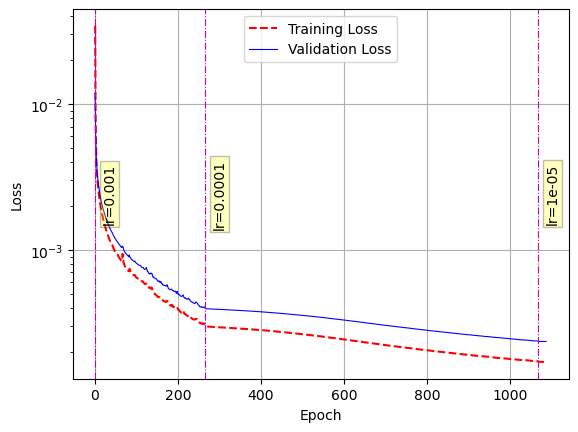

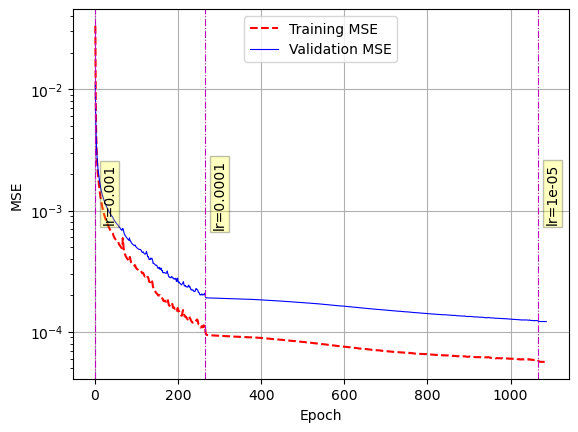

<Figure size 640x480 with 0 Axes>

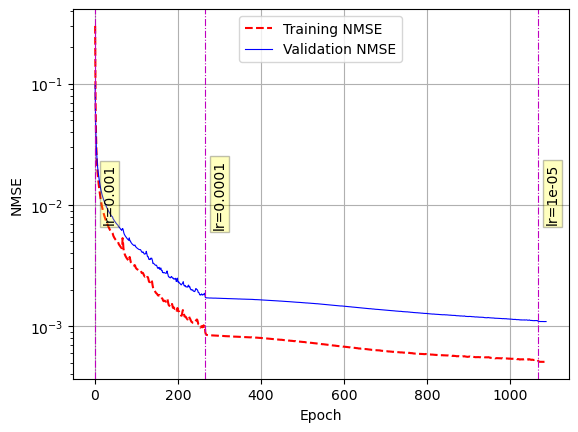

<Figure size 640x480 with 0 Axes>

In [37]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


data_idx : 52


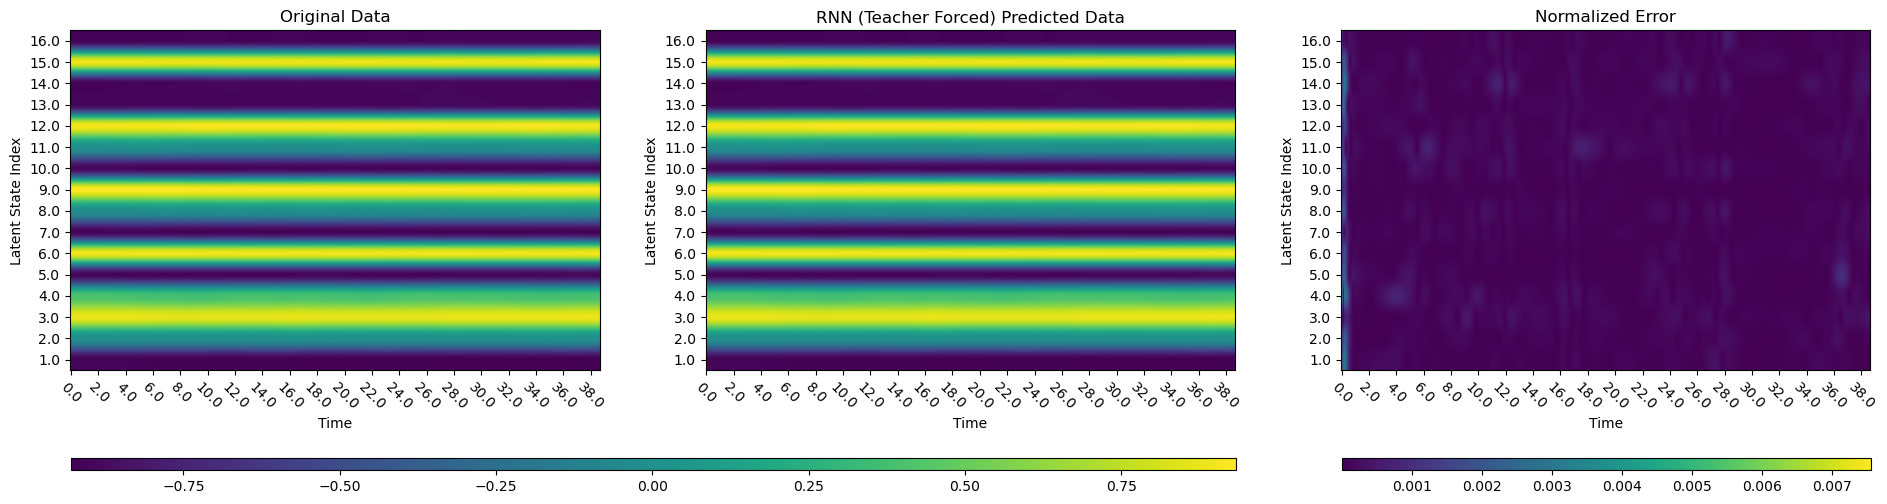

In [38]:
# data_type = 'training'
rnn_net.reset_states()
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [39]:
prediction.shape, data_out.shape, rnn_net.stateful

((64, 387, 16), (387, 16), True)

In [40]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = np.empty_like(data)
    shape = new_data.shape
    print(shape)
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] = data[:, i]
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] = data[:, :, i]
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 26


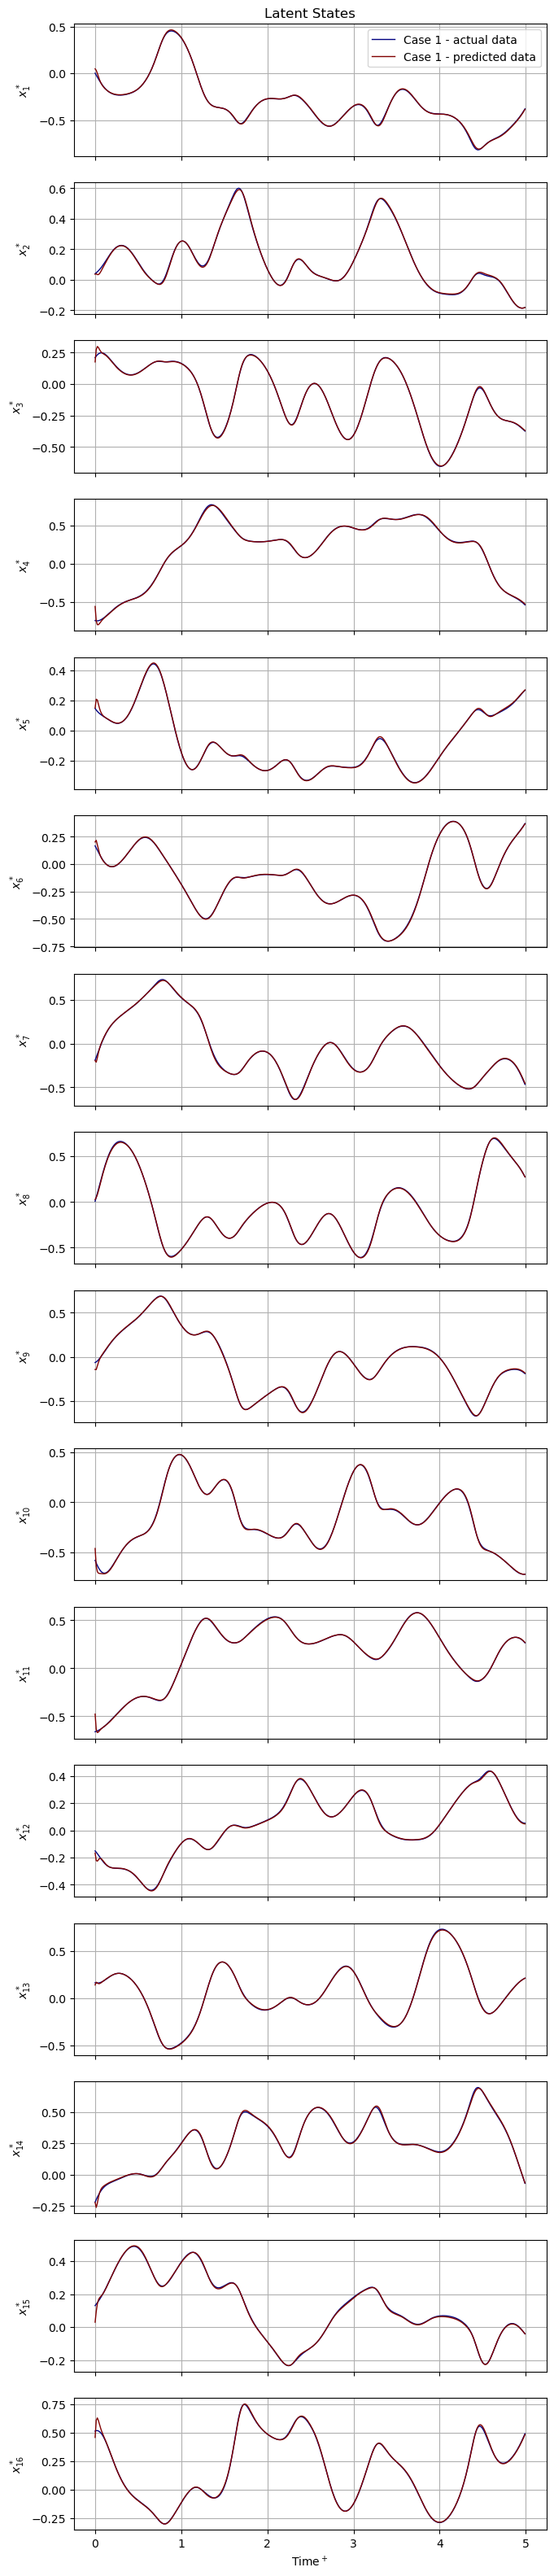


4.991497332033017


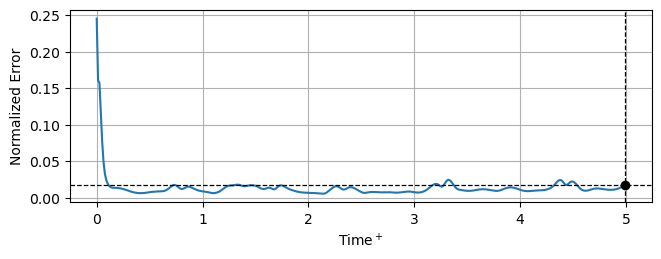

In [41]:
if rnn_net.stateful == True:
    for rnn_layer in rnn_net.rnn_list:
        rnn_layer.reset_states()


data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
# data_out = invert_normalization(data_out, normalization_arr)

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# prediction = rnn_net(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = invert_normalization(prediction, normalization_arr)

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

plt.show()

In [42]:
normalization_arr

array([[-9.1677707e-01,  1.2992923e-04,  8.7233132e-01,  3.7813839e-01,
        -9.0630871e-01,  9.0002370e-01, -9.0762734e-01,  9.5153734e-04,
         9.2579836e-01, -9.0078872e-01,  1.9794800e-03,  9.0746152e-01,
        -8.9683348e-01, -9.0368670e-01,  8.8886255e-01, -9.0797812e-01],
       [ 1.7214341e-02,  2.1547530e-02,  2.6943050e-02,  3.1309322e-02,
         1.9383600e-02,  1.8176436e-02,  2.0488238e-02,  2.0800367e-02,
         1.3326870e-02,  1.7405285e-02,  2.8398164e-02,  1.9142920e-02,
         2.0364299e-02,  2.0542476e-02,  2.2748180e-02,  1.6764373e-02]],
      dtype=float32)

# Autoregressive Mode

In [43]:
# s_in = testing_data_rnn_input.shape
# testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# # testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

# s_out = testing_data_rnn_output.shape
# testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# # testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [44]:
temp1 = np.empty_like(testing_data_rnn_input)
temp2 = np.empty_like(testing_data_rnn_output)

begin_idx = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_test = num_test_arr[i]

    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        temp1[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]
        temp2[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]

    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

In [45]:
testing_data_rnn_input_og = testing_data_rnn_input
testing_data_rnn_output_og = testing_data_rnn_output

testing_data_rnn_input = temp1
testing_data_rnn_output = temp2

In [46]:
s_in = testing_data_rnn_input.shape
testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

s_out = testing_data_rnn_output.shape
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [47]:
T_sample_input_AR = 1*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 10*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx : 0
data_idx : 2454
data_.shape : (1, 850, 16)


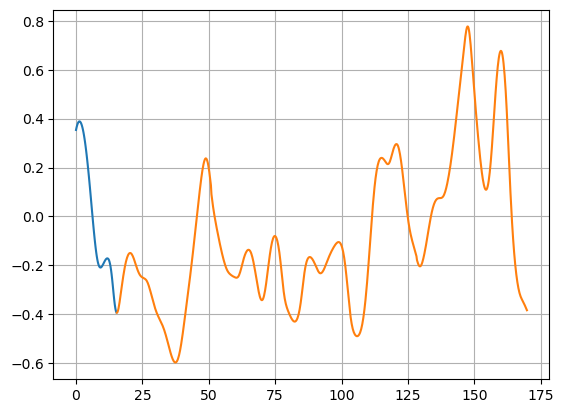

In [48]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(dt_rnn*np.arange(num_sample_input_AR), data_[0, 0:num_sample_input_AR, 0])
plt.plot(dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR), data_[0, num_sample_input_AR:, 0])
plt.grid(True)
plt.show()

In [49]:
prediction_lst = []

for layer in rnn_net.rnn_list:
    if layer.stateful == True:
        layer.reset_states()

    if data_.shape[0] != batch_size:
        data_ = np.tile(data_, (batch_size, 1, 1))
input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR, :]))

prediction_lst.append(input_preds[:, -2:-1, :])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array(prediction_lst[-1])
    output = np.array(rnn_net(data_in_i, training=False))
    prediction_lst.append(output[:, 0:1, :])

In [50]:
prediction_lst = np.stack(prediction_lst)
prediction_lst = np.squeeze(prediction_lst)
if rnn_net.stateful == True:
    prediction_lst = np.transpose(prediction_lst, [1, 0, 2])
# print(np.squeeze(prediction_lst).shape)
# print(np.transpose(prediction_lst, [1, 0, 2]).shape)

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

input_preds.shape : (64, 77, 16)
prediction_lst.shape : (64, 773, 16)


In [51]:
data_ = data_[0:1]
if rnn_net.stateful == True:
    prediction_lst = prediction_lst[0]
input_preds = input_preds[0]

0.5560476302523827


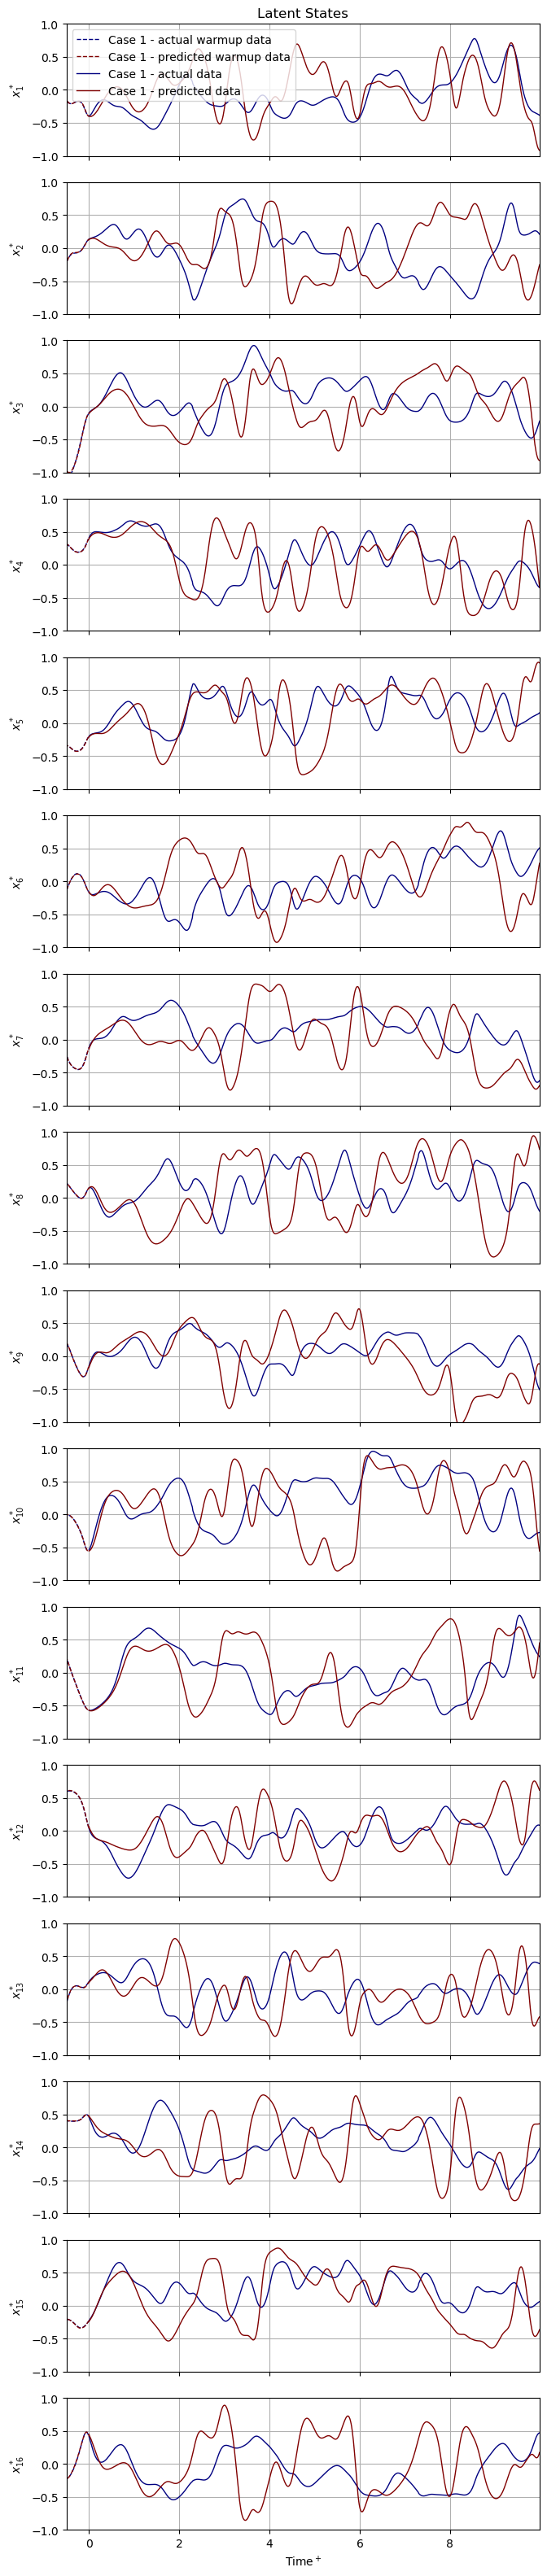

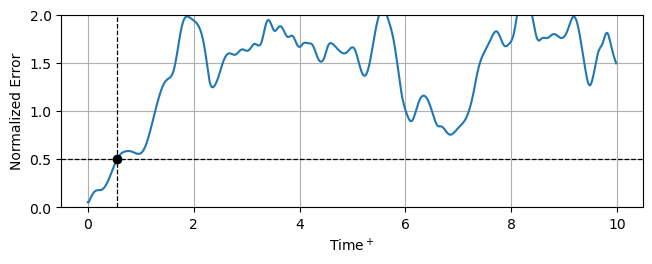

In [52]:
lyap_time = np.mean(lyapunov_time_arr)

n = 1
num_latent_states = input_preds.shape[-1]
N = num_sample_output_AR#num_output_timesteps

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, data_[0, 0:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, data_[0, num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst[:, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (data_[0, num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[:, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

In [53]:
# sp = np.array([var.numpy() for var in rnn_net.scalar_multiplier_pre_list])
# print(sp)
# sum_ = np.sum(np.exp(sp))
# print(np.exp(sp)/sum_)

In [54]:
rnn_net.dense[-1].weights

[<tf.Variable 'rnn_gru/time_distributed_1/individual_weights:0' shape=(16,) dtype=float32, numpy=
 array([1.3799715, 1.5780429, 1.3565214, 1.1292351, 1.3345951, 1.4867152,
        1.2954178, 1.5445392, 1.4475704, 1.2686435, 1.3395574, 1.02306  ,
        1.3340223, 1.0797461, 1.2770658, 1.3772066], dtype=float32)>]